# 03 Experiments with pre-defined splits

One of the benefits of the disjoint generative models approach, is the ability to use different models for different subsets of the data. For example using a model that is good for nummerical attributes to model those variables and using a model that is good for categorical attributes for them.

In the following we will show how this can be done to the benefit of the synthetic data quality. 

The example will be based on the Hepatitis dataset from the UCI repository. The dataset contains ~1300 rows and 29 columns. The columns are a mix of categorical and numerical attributes. The dataset contains no missing values. We report the average metric result and standard error of the mean for 10 repeated rund of the experiment with 80% of the data used for training and 20% for the metrics that require holdout data.

In [2]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from joblib import Parallel, delayed

from syntheval import SynthEval

from sklearn.ensemble import RandomForestClassifier
from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator
from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "pca"       : {},
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"  : {"num_eval_iter": 5},
}

In [3]:
### Load training and testing datasets and define categorical and numerical attributes

df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

print(cat_atts)
print(num_atts)

df_train.head()

['WBC', 'RBC', 'Plat', 'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF', 'Gender', 'Fever', 'Nausea/Vomting', 'Headache', 'Diarrhea', 'Fatigue & generalized bone ache', 'Jaundice', 'Epigastric pain', 'b_class']
['Age', 'BMI', 'HGB', 'AST 1', 'ALT 1', 'ALT 4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w', 'Baseline histological Grading']


,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,b_class
0,47,2,32,2,2,1,2,2,2,2,...,87,56,39,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",11,1
1,36,2,24,2,1,2,2,2,1,2,...,108,74,45,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",3,1
2,50,1,34,1,1,2,1,2,2,2,...,71,125,28,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",9,1
3,32,2,30,1,2,1,2,2,1,1,...,102,84,40,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",6,0
4,58,1,29,2,2,1,1,2,2,1,...,55,40,40,"(5, 1201086]","(5, 1201715]","(0, 5]","(0, 5]","(0, 5]",15,1


In [3]:
### Background measurement
SE = SynthEval(df_train, df_test, verbose=False)
SE.evaluate(df_train, analysis_target_var=label,**metrics)

,metric,dim,val,err,n_val,n_err
0,pca_eigval_diff,u,0.000000e+00,NaN,1.000000,NaN
1,pca_eigvec_ang,u,3.420361e-08,NaN,1.000000,NaN
2,avg_h_dist,u,0.000000e+00,0.000000,1.000000,0.000000
3,corr_mat_diff,u,0.000000e+00,NaN,1.000000,NaN
4,auroc,u,0.000000e+00,NaN,1.000000,NaN
5,cls_F1_diff,u,0.000000e+00,0.007357,1.000000,0.007357
6,cls_F1_diff_hout,u,0.000000e+00,0.000000,1.000000,0.000000
7,eps_identif_risk,p,0.000000e+00,NaN,1.000000,NaN
8,priv_loss_eps,p,-2.090498e-01,NaN,0.790950,NaN
9,median_DCR,p,1.000000e+00,NaN,0.761594,NaN


In [4]:

def model_experiment(df_train: DataFrame, df_test: DataFrame, label: str, model: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of a generative model on the same 
    dataset and return best estimate of the mean of the various metrics. 
    """
    SE = SynthEval(df_train, df_test, verbose=False)

    dfs_list = Parallel(n_jobs=-1)(delayed(generate_synthetic_data)(df_train, model, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}
    
    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
cart_results = model_experiment(df_train, df_test, label, 'synthpop', metrics)
cart_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop.csv')

In [ ]:
bn_results = model_experiment(df_train, df_test, label, 'datasynthesizer', metrics)
bn_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer.csv')
#~12 mins

In [ ]:
ctgan_results = model_experiment(df_train, df_test, label, 'ctgan', metrics)
ctgan_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/ctgan.csv')
#~79 mins

In [ ]:
adsgan_results = model_experiment(df_train, df_test, label, 'adsgan', metrics)
adsgan_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/adsgan.csv')
#~73 mins

In [ ]:
dpgan_results = model_experiment(df_train, df_test, label, 'dpgan', metrics)
dpgan_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/dpgan.csv')

### Now do the many combinations of mixed models
We use synthpop and DataSynthesizer for the categorical attributes and CTGAN, ADSGAN and DPGAN for the nummerical attributes.

In [4]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """
    Rf = RandomForestClassifier(n_estimators=100)
    JS = UsingJoiningValidator(JoiningValidator(Rf, verbose=False), behaviour='adaptive')

    dgms = DisjointGenerativeModels(df_train, gms, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = {model1: cat_atts, model2: num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop_ctgan.csv')
#~12 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop_adsgan.csv')
#~12 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop_dpgan.csv')
#~9 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer_ctgan.csv')
#~14 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv')
#~12 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv')
#~11 mins

In [4]:
### Read all the results and present them in a joint dataframe

res_dfs = {
    'sp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop.csv', index_col=0),
    'ds': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer.csv', index_col=0),
    'ct': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/ctgan.csv', index_col=0),
    'ad': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/adsgan.csv', index_col=0),
    'dp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/dpgan.csv', index_col=0),
    'sp_ct': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop_ctgan.csv', index_col=0),
    'sp_ad': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop_adsgan.csv', index_col=0),
    'sp_dp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/synthpop_dpgan.csv', index_col=0),
    'ds_ct': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer_ctgan.csv', index_col=0),
    'ds_ad': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv', index_col=0),
    'ds_dp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', index_col=0),
}

In [5]:
### Create a joint dataframe with all the results

df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
sp    mean         0.019252        0.302412    0.006135       0.385228   
      sem          0.002000        0.024042    0.000351       0.009788   
ds    mean         0.013639        0.592059    0.009862       0.401531   
      sem          0.001394        0.081888    0.000479       0.006635   
ct    mean         0.021003        0.684742    0.012902       0.749031   
      sem          0.002019        0.080113    0.001027       0.017997   
ad    mean         0.023197        0.618843    0.012913       0.711759   
      sem          0.002175        0.047018    0.000606       0.026300   
dp    mean         0.293979        0.778371    0.282178       2.664352   
      sem          0.030328        0.071143    0.009695       0.020058   
sp_ct mean         0.041156        0.617996    0.014475       0.630407   
      sem          0.002247        0.051512    0.000938       0.019687   
sp_ad mean         0.039517        0.584647    0.013370       0.616504   
      sem          0.003411        0.045858    0.000788       0.018185   
sp_dp mean         0.296602        0.826771    0.054575       1.378945   
      sem          0.024598        0.055339    0.001879       0.077149   
ds_ct mean         0.039161        0.670823    0.012825       0.598665   
      sem          0.002245        0.049928    0.001198       0.012481   
ds_ad mean         0.040224        0.659892    0.013285       0.599734   
      sem          0.002632        0.061018    0.000943       0.007808   
ds_dp mean         0.279960        0.801992    0.053954       1.543279   
      sem          0.010220        0.081386    0.003716       0.117489   

               auroc  cls_F1_diff  cls_F1_diff_hout  eps_identif_risk  \
sp    mean  0.030020     0.021546          0.014096          0.565611   
      sem   0.008167     0.001931          0.003346          0.003518   
ds    mean  0.030105     0.016785          0.010932          0.610679   
      sem   0.005860     0.001429          0.001742          0.007522   
ct    mean  0.021945     0.016291          0.020439          0.487421   
      sem   0.004339     0.002010          0.002215          0.005687   
ad    mean  0.032212     0.023743          0.021591          0.490045   
      sem   0.007911     0.002509          0.002474          0.002953   
dp    mean  0.018182     0.203000          0.218502          0.024796   
      sem   0.004409     0.012782          0.012599          0.007098   
sp_ct mean  0.033440     0.019534          0.018105          0.454842   
      sem   0.008339     0.002156          0.002218          0.005093   
sp_ad mean  0.012416     0.020790          0.024526          0.472127   
      sem   0.003371     0.000953          0.004084          0.005035   
sp_dp mean  0.034391     0.030587          0.045761          0.031855   
      sem   0.007709     0.005337          0.009398          0.004828   
ds_ct mean  0.031022     0.023426          0.020513          0.448869   
      sem   0.007082     0.002461          0.004130          0.012292   
ds_ad mean  0.025740     0.019792          0.021821          0.464163   
      sem   0.005101     0.002223          0.002625          0.003890   
ds_dp mean  0.019184     0.026126          0.040952          0.032217   
      sem   0.003032     0.004600          0.005502          0.008490   

            priv_loss_eps  median_DCR  mia_recall  mia_precision  
sp    mean       0.364615    0.953044    0.507536       0.519813  
      sem        0.003654    0.002404    0.010464       0.007689  
ds    mean       0.405701    0.978224    0.507536       0.510354  
      sem        0.006844    0.001516    0.008472       0.004800  
ct    mean       0.285430    0.981027    0.326957       0.511681  
      sem        0.005301    0.002958    0.011216       0.009856  
ad    mean       0.289321    0.983680    0.346377       0.503636  
      sem        0.003440    0.002415    0.007487       0.007173  
dp    mean       0.006878 

## Results for other datasets
We repeated the additional datasets using the DataSynthesizer-DPGAN DGM. The results are shown in the figure.

/home/lautrup/repositories/disjoint-synthetic-data-generation/experiments/auxiliaries/plotting.py:64: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-

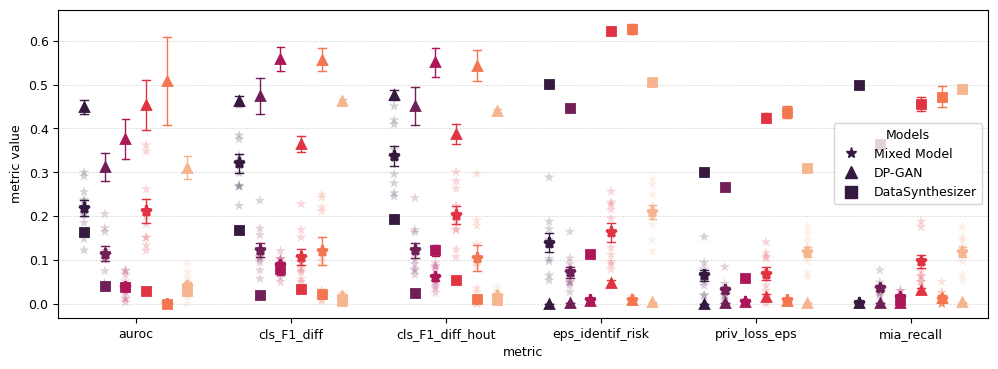

In [1]:
from experiments.auxiliaries.plotting import make_relative_derviation_histogram

datasets = ['al', 'bc', 'cc', 'hd', 'kd', 'st']
make_relative_derviation_histogram(datasets, models=['datasynthesizer', 'dpgan'])

## Comparison of results with strict and adapive validators

Quickly calculate the percentage difference in results and measure z-scores

In [20]:
import numpy as np

from scipy.stats import norm

models_to_check = ['datasynthesizer_ctgan', 'datasynthesizer_adsgan', 'datasynthesizer_dpgan', 'synthpop_ctgan', 'synthpop_adsgan', 'synthpop_dpgan']

for model in models_to_check:
    print(model)
    
    res_adapt = pd.read_csv(f'experiments/results/mixed_model_results/hepatitis_case_study_adapt/{model}.csv', index_col=0)
    res_strict = pd.read_csv(f'experiments/results/mixed_model_results/hepatitis_case_study_strict/{model}.csv', index_col=0)

    # drop the pca rows 
    res_adapt = res_adapt.drop(index=['pca_eigval_diff'])
    res_adapt = res_adapt.drop(index=['pca_eigvec_ang'])

    # calculate percentage difference
    res_diff = (res_strict['mean'] -res_adapt['mean']) / res_adapt['mean'] * 100

    # calculate the z-score for the difference
    z_score = (res_strict['mean'] - res_adapt['mean']) / np.sqrt(res_adapt['sem']**2+res_strict['sem']**2)

    # get p-values
    p_values = 2 * (1 - norm.cdf(np.abs(z_score)))
    p_values = pd.Series(p_values, index=res_adapt.index)

    res = pd.concat([res_adapt['mean'], res_strict['mean'], res_diff, z_score, p_values], axis=1, keys=['adapt', 'strict', 'diff %', 'z_score', 'p_value'])
    print(res)
    

datasynthesizer_ctgan
                     adapt    strict     diff %   z_score   p_value
avg_h_dist        0.012825  0.016411  27.964807  2.520255  0.011727
corr_mat_diff     0.598665  0.685781  14.551717  3.891990  0.000099
auroc             0.031022  0.019819 -36.113688 -1.275894  0.201993
cls_F1_diff       0.023426  0.027228  16.229446  0.899271  0.368509
cls_F1_diff_hout  0.020513  0.030941  50.836434  1.907478  0.056459
eps_identif_risk  0.448869  0.429231  -4.375000 -1.449314  0.147250
priv_loss_eps     0.260000  0.249502  -4.037591 -0.885688  0.375786
median_DCR        0.973517  0.977280   0.386557  0.869725  0.384451
mia_recall        0.262609  0.264348   0.662252  0.109423  0.912867
mia_precision     0.491967  0.514394   4.558636  1.862199  0.062575
datasynthesizer_adsgan
                     adapt    strict     diff %   z_score       p_value
avg_h_dist        0.013285  0.019571  47.313848  4.566601  4.956956e-06
corr_mat_diff     0.599734  0.701595  16.984379  6.796172  1.07